In [ ]:
### If needed, install additional modules:
#!pip3 install pandas
#!pip3 install matplotlib
### interactive plotting in jupyterlab requires node.js (pip does not install it!!):
#!apt update && apt install -y nodejs
#!pip3 install ipympl
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#!jupyter labextension install jupyter-matplotlib
#!jupyter nbextension enable --py widgetsnbextension
### DON'T FORGET TO RESTART JupyterLab !!
# start jupyterlab:
# jupyter lab --ip=0.0.0.0

First we import necessary packages:

In [1]:
import numpy as np
import matplotlib.style as mplstyle
mplstyle.use('fast')
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
from scipy import signal
#%matplotlib --list

# for interactive plot, may change to widget, if installed
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

debug = False

Let's construct a few helper functions:

In [2]:
def build_url(**kwargs):
    """A general function to build URL based on kwargs
    """
    url = kwargs['base_url'].rstrip("?") + "?"
    k = 0
    params = ""
 
    for key,val in kwargs.items():
        if type(val) is list:
            if len(val) > 0 and key != 'exclude':
                params += key + '='
                for v in val:
                    params += str(v) + ',' if v not in kwargs['exclude'] else ''
                params = params.rstrip(',')
        elif key != 'base_url' and key != 'exclude':
            params += key + '=' + str(val)
 
        params += '&'
    
    url += params.lstrip('&').rstrip('&')
    return url

In [3]:
def simple_plot(data, legend=False):
    """Simple function to produce plot based on retrieved data
    :param data: input data (list)
    """
    for curve in data:
        plt.plot(pd.to_datetime(curve['x']), curve['y'], label=curve['model'])
    
    ax = plt.gca() # get axis instance
    ax_pos = ax.get_position() # get the axes position
    num_col = len(data) // 12
    num_col = num_col if (num_col % 12 == 0 and num_col > 0 ) else num_col + 1
    handles, labels = ax.get_legend_handles_labels()
    if legend:
      plt.legend(handles=handles,
                loc='upper center', 
                bbox_to_anchor=[0., ax_pos.y0-0.1, 0.99, 0.3],
                ncol=num_col, fancybox=True, fontsize='small',
                borderaxespad=0.)
    plt.show

In [4]:
def data_to_pandas(data):
  """Combine JSON data series in one pandas Dataframe
  :param data: input data (list with dict as elements)
  """
  # put data in pandas
  data_pd = pd.DataFrame()
  k_c = 0
  pd.options.display.max_columns = None
  for output in data:
    print(output)  if debug else ''
    # construct a dataframe: 'x' -> 'time', 'y' -> 'model_name' columns
    curve = pd.DataFrame({'time': pd.to_datetime(output['x']), output['model']: output['y']})
    print(curve.head()) if debug else ''
    print(curve.tail()) if debug else ''
    # merge different curves in on Dataframe, sort along 'time'
    if k_c == 0:
      data_pd = curve
    else:
      data_pd = data_pd.merge(curve, how='outer', on=['time'], sort=True)
    k_c += 1
 
  # set 'time' as Dataframe index
  data_pd = data_pd.set_index('time')
  return data_pd.replace({0: np.nan})

In [5]:
def boxcar(data, bwin):
  """Function to apply boxcar, following
  https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
  N.B. 'valid' replaced with 'same' !
  """

  boxcar = np.ones(bwin)
  print("signal(raw) (len={}): {}".format(len(data),data)) if debug else ''
  # may have a problem with NaNs. try to interpolate. somehow does not work... comment.
  # https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array?noredirect=1&lq=1
  #nans, x= np.isnan(data), lambda z: z.nonzero()[0]
  #data[nans]= np.interp(x(nans), x(~nans), data[~nans])
  # mirror start and end of the original signal:
  sgnl = np.r_[data[bwin-1:0:-1],data,data[-2:-bwin-1:-1]]
  print("signal (len={}): {}".format(len(sgnl),sgnl)) if debug else ''
  boxcar_values = signal.convolve(sgnl,
                                  boxcar, 
                                  mode='same')/bwin
  print("signal+boxcar (len={}): {}".format(len(boxcar_values), 
                                            boxcar_values)) if debug else ''
  return boxcar_values[bwin-1:-(bwin-1)]

We define a few variables needed for every REST API call:

In [6]:
url_o3api = "http://o3api.test.fedcloud.eu:30505/api/"

In [7]:
headers = {'Content-Type': 'application/json',
           'Accept': 'application/json'}

We will analyse refC2 models, therefore we first request the list of corresponding models via the REST API

In [8]:
# Let's work with refC2 models:
url_o3api_tco3_zm_models = os.path.join(url_o3api, "models/list/tco3_zm?select=refC2")

In [9]:
# request the list of modesl from O3as API:
tco3_zm_models = requests.request("POST", url=url_o3api_tco3_zm_models, headers=headers).json()
print(tco3_zm_models)

['CCMI-1_ACCESS_ACCESS-CCM-refC2', 'CCMI-1_CCCma_CMAM-refC2', 'CCMI-1_CESM1-CAM4Chem_refC2_r1i1p1', 'CCMI-1_CESM1-CAM4Chem_refC2_r2i1p1', 'CCMI-1_CESM1-CAM4Chem_refC2_r3i1p1', 'CCMI-1_CESM1-WACCM_refC2_r1i1p1', 'CCMI-1_CESM1-WACCM_refC2_r2i1p1', 'CCMI-1_CESM1-WACCM_refC2_r3i1p1', 'CCMI-1_CHASER-MIROC-ESM-refC2', 'CCMI-1_CNRM-CERFACS_CNRM-CM5-3-refC2', 'CCMI-1_CNRM-CERFACS_MOCAGE-refC2', 'CCMI-1_ETH-PMOD_SOCOL3-refC2', 'CCMI-1_GSFC_GEOSCCM-refC2', 'CCMI-1_MESSy_EMAC-L90MA-refC2', 'CCMI-1_MOHC_HadGEM3-ES-refC2', 'CCMI-1_MRI_ESM1r1-refC2', 'CCMI-1_NIES_CCSRNIES-MIROC3.2-refC2', 'CCMI-1_NIWA_NIWA-UKCA-refC2', 'CCMI-1_U-CAMBRIDGE_UMUKCA-UCAM-refC2', 'CCMI-1_U-LAQUILA_CCM-refC2', 'CCMI-1_U-LEEDS_UMSLIMCAT-refC2']


Next we build up parameters to retrieve data. In the example we request:
*   South Hemisphere (SH, latitudes: -90, -60)
*   month: October
*   range of years: (1960, 2100)
we also exclude one model, CCMI-1_IPSL-refC2






In [13]:
kwargs_tco3_zm = {}
 
# Build kwargs with tco3_zm parameters for O3as API. 
# Keys have to correspond to expected by the API keys!
# 'base_url' and 'exclude' are special keys for this notebook, not for the API
kwargs_tco3_zm['base_url'] = os.path.join(url_o3api, "data/tco3_zm?")
kwargs_tco3_zm['begin_year'] = 1960
kwargs_tco3_zm['end_year'] = 2099
kwargs_tco3_zm['month'] = [10]
kwargs_tco3_zm['lat_min'] = -90
kwargs_tco3_zm['lat_max'] = -60
kwargs_tco3_zm['model'] = tco3_zm_models
kwargs_tco3_zm['exclude'] = ['CCMI-1_IPSL-refC2'] #'CCMI-1_IPSL-refC2'

Finally, we call the REST API and retrieve data.

In [14]:
# Build the API URL:
url_o3api_plot_tco3_zm = build_url(**kwargs_tco3_zm)
print(url_o3api_plot_tco3_zm)

http://o3api.test.fedcloud.eu:30505/api/data/tco3_zm?begin_year=1960&end_year=2099&month=10&lat_min=-90&lat_max=-60&model=CCMI-1_ACCESS_ACCESS-CCM-refC2,CCMI-1_CCCma_CMAM-refC2,CCMI-1_CESM1-CAM4Chem_refC2_r1i1p1,CCMI-1_CESM1-CAM4Chem_refC2_r2i1p1,CCMI-1_CESM1-CAM4Chem_refC2_r3i1p1,CCMI-1_CESM1-WACCM_refC2_r1i1p1,CCMI-1_CESM1-WACCM_refC2_r2i1p1,CCMI-1_CESM1-WACCM_refC2_r3i1p1,CCMI-1_CHASER-MIROC-ESM-refC2,CCMI-1_CNRM-CERFACS_CNRM-CM5-3-refC2,CCMI-1_CNRM-CERFACS_MOCAGE-refC2,CCMI-1_ETH-PMOD_SOCOL3-refC2,CCMI-1_GSFC_GEOSCCM-refC2,CCMI-1_MESSy_EMAC-L90MA-refC2,CCMI-1_MOHC_HadGEM3-ES-refC2,CCMI-1_MRI_ESM1r1-refC2,CCMI-1_NIES_CCSRNIES-MIROC3.2-refC2,CCMI-1_NIWA_NIWA-UKCA-refC2,CCMI-1_U-CAMBRIDGE_UMUKCA-UCAM-refC2,CCMI-1_U-LAQUILA_CCM-refC2,CCMI-1_U-LEEDS_UMSLIMCAT-refC2


In [15]:
# Request data
response = requests.request("POST", url=url_o3api_plot_tco3_zm, headers=headers)
# Read the status_code. Normal response => 200
print(response.status_code)
tco3_zm_data = response.json()
#print(tco3_zm_data[:10])

200


The received JSON data are converted into pandas Dataframe.

In [16]:
# put data in pandas
tco3_zm_pd = data_to_pandas(tco3_zm_data)
 
print(tco3_zm_pd.head()) if debug else ''
print(tco3_zm_pd.tail()) if debug else ''
print(tco3_zm_pd.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 423 entries, 1959-10-16 12:00:00+00:00 to 2100-10-16 12:00:00+00:00
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   CCMI-1_ACCESS_ACCESS-CCM-refC2        141 non-null    float64
 1   CCMI-1_CCCma_CMAM-refC2               141 non-null    float64
 2   CCMI-1_CESM1-CAM4Chem_refC2_r1i1p1    142 non-null    float64
 3   CCMI-1_CESM1-CAM4Chem_refC2_r2i1p1    141 non-null    float64
 4   CCMI-1_CESM1-CAM4Chem_refC2_r3i1p1    141 non-null    float64
 5   CCMI-1_CESM1-WACCM_refC2_r1i1p1       141 non-null    float64
 6   CCMI-1_CESM1-WACCM_refC2_r2i1p1       141 non-null    float64
 7   CCMI-1_CESM1-WACCM_refC2_r3i1p1       141 non-null    float64
 8   CCMI-1_CHASER-MIROC-ESM-refC2         141 non-null    float64
 9   CCMI-1_CNRM-CERFACS_CNRM-CM5-3-refC2  140 non-null    float64
 10  CCMI-1_CNRM-CERFACS_MOCAGE-refC2     

Let's plot the retrieved data:

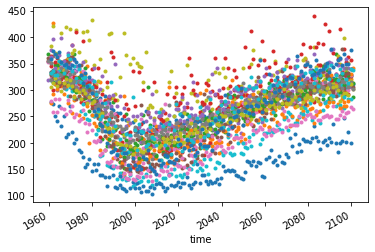

In [20]:
tco3_zm_pd.plot(marker='.', legend=False) # have to pu "marker='.'" because of many NANs

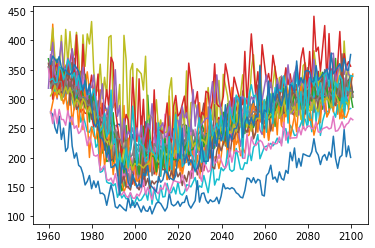

In [21]:
%matplotlib inline

# to cross check, can also plot retrieved JSON data
simple_plot(tco3_zm_data)

Now, in the similar way we retrieve the observational data:

In [22]:
# Select data with the measurements:
url_o3api_tco3_zm_meas = os.path.join(url_o3api, "models/list/tco3_zm?select=SAT")

In [23]:
tco3_zm_meas = requests.request("POST", url=url_o3api_tco3_zm_meas, headers=headers).json()
print(tco3_zm_meas)

['ESACCI_DLR-merged-SAT-ozone', 'SBUV_GSFC_merged-SAT-ozone']


In [24]:
#kwargs_tco3_zm['month'] = []
kwargs_tco3_zm['model'] = tco3_zm_meas

In [25]:
url_o3api_plot_tco3_meas = build_url(**kwargs_tco3_zm)
print(url_o3api_plot_tco3_meas)

http://o3api.test.fedcloud.eu:30505/api/data/tco3_zm?begin_year=1960&end_year=2099&month=10&lat_min=-90&lat_max=-60&model=ESACCI_DLR-merged-SAT-ozone,SBUV_GSFC_merged-SAT-ozone


In [26]:
# request data
response = requests.request("POST", url=url_o3api_plot_tco3_meas, headers=headers)
# read the status_code. Normal response => 200
print(response.status_code)
tco3_zm_meas_json = response.json()
#print(tco3_zm_meas[:1])

200


In [27]:
# put data in pandas
tco3_zm_meas_pd = data_to_pandas(tco3_zm_meas_json)
print(tco3_zm_meas_pd.head()) if debug else ''
print(tco3_zm_meas_pd.tail()) if debug else ''
print(tco3_zm_meas_pd.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45 entries, 1970-10-01 00:00:00+00:00 to 2016-10-01 00:00:00+00:00
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ESACCI_DLR-merged-SAT-ozone  15 non-null     float64
 1   SBUV_GSFC_merged-SAT-ozone   44 non-null     float64
dtypes: float64(2)
memory usage: 1.1 KB
None


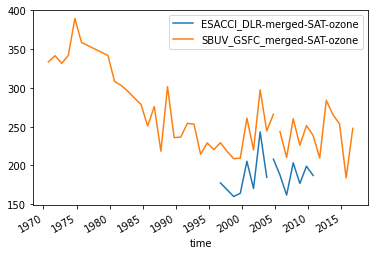

In [28]:
%matplotlib inline

tco3_zm_meas_pd.plot()

In [29]:
#simple_plot(tco3_zm_meas_json)

Next, we:
1.  Average simulated data over one year
2.  Apply 10-point (10-years) boxcar smoothing
3.  Define the reference year
4.  For the reference year, find the TCO3 value in the measured data (reference value)
5.  Find biases in the simulation data in relation to the reference year
6.  Shift all simulations to the reference value at the reference year
7.  Plot shifted models together with the reference value.



''

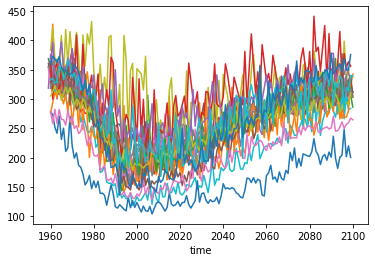

In [30]:
# Average model data per year, index -> year
tco3_zm_year_pd = tco3_zm_pd.groupby([tco3_zm_pd.index.year]).mean()
tco3_zm_year_pd.plot(legend=False)
print(tco3_zm_year_pd.head()) if debug else ''

2100


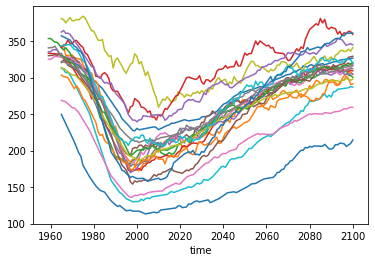

In [31]:
print(tco3_zm_year_pd['CCMI-1_ACCESS-refC2']) if debug else ''
last_year = tco3_zm_year_pd.index.values[-1]
print(last_year)
boxcar_window = 10 # boxcar window for smoothing
# if last years have NaNs fill them with "before NaN values"
tco3_zm_year_pd[tco3_zm_year_pd.index > (last_year - boxcar_window)] = tco3_zm_year_pd[tco3_zm_year_pd.index > (last_year - boxcar_window)].fillna(method='ffill')
tco3_zm_smooth_pd = tco3_zm_year_pd.apply(boxcar, args = [boxcar_window], axis = 0, result_type = 'broadcast')
print(tco3_zm_smooth_pd['CCMI-1_ACCESS-refC2']) if debug else ''
tco3_zm_smooth_pd.plot(legend=False)

In [32]:
# Reference measurement for a year
refYear = 1980
refMeasurement = 'SBUV_GSFC_merged-SAT-ozone'
refValue = tco3_zm_meas_pd[refMeasurement][tco3_zm_meas_pd.index.year == refYear].interpolate(method='linear').values
refValue = np.mean(refValue)
print(refValue)

308.17499999999995


In [33]:
# Calculate shift values for every model (refValue - modelValue for refYear)
tco3_zm_shift = refValue - tco3_zm_smooth_pd[tco3_zm_smooth_pd.index == refYear]
print(tco3_zm_shift) if debug else ''

''

In [34]:
tco3_zm_refYear = tco3_zm_smooth_pd + tco3_zm_shift.values
# rebin also measured data to yearly data
tco3_zm_meas_year = tco3_zm_meas_pd.groupby([tco3_zm_meas_pd.index.year]).mean()
print(tco3_zm_meas_year.head())

      ESACCI_DLR-merged-SAT-ozone  SBUV_GSFC_merged-SAT-ozone
time                                                         
1970                          NaN                     333.500
1971                          NaN                     341.375
1972                          NaN                     331.600
1973                          NaN                     341.650
1974                          NaN                     389.400


In [35]:
# Create an empty DataFrame for statistics (can have better control how to plot it later)
tco3_zm_refYear_stat = pd.DataFrame(index=tco3_zm_refYear.index, columns=['Mean', 'Std', 'Median'])
# Fill 'Mean' values
tco3_zm_refYear_stat["Mean"] = tco3_zm_refYear.mean(axis=1, skipna=True)
tco3_zm_refYear_stat["Std"] = tco3_zm_refYear.std(axis=1, skipna=True)
tco3_zm_refYear_stat["Mean-Std"] = tco3_zm_refYear_stat["Mean"] - tco3_zm_refYear_stat["Std"]
tco3_zm_refYear_stat["Mean+Std"] = tco3_zm_refYear_stat["Mean"] + tco3_zm_refYear_stat["Std"]
tco3_zm_refYear_stat["Median"] = tco3_zm_refYear.median(axis=1, skipna=True)
print(tco3_zm_refYear_stat.head)

<bound method NDFrame.head of             Mean        Std      Median    Mean-Std    Mean+Std
time                                                           
1959  365.198694  16.475146  366.747139  348.723547  381.673840
1960  365.198694  16.475146  366.747139  348.723547  381.673840
1961  365.709937  15.447945  366.985629  350.261992  381.157882
1962  365.992235  14.092046  367.573888  351.900188  380.084281
1963  364.800871  14.744246  364.989322  350.056624  379.545117
...          ...        ...         ...         ...         ...
2096  341.735308  20.454218  343.783609  321.281090  362.189526
2097  342.816685  20.515508  343.380080  322.301177  363.332192
2098  343.096684  20.293321  340.805014  322.803363  363.390005
2099  343.435742  20.372278  342.007556  323.063464  363.808020
2100  343.356741  20.102651  340.913956  323.254090  363.459393

[142 rows x 5 columns]>


Text(0, 0.5, 'tco3_zm (DU)')

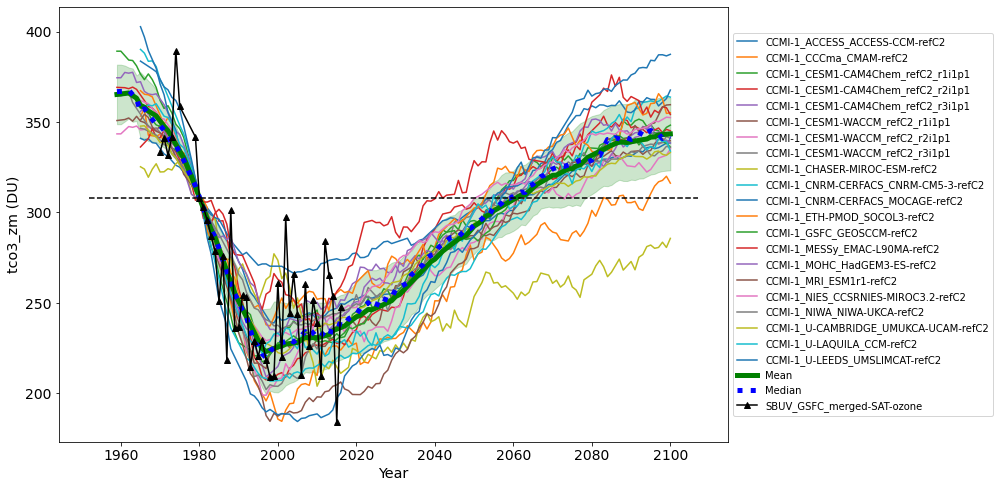

In [42]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

tco3_zm_refYear.plot()
xmin, xmax = plt.xlim()

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.hlines(refValue, xmin, xmax, 
           colors='k', # 'dimgray'..? 
           linestyles='dashed',
           zorder=256)
tco3_zm_refYear_stat['Mean'].plot(linewidth=5, color='g') #, yerr=tco3_zm_refYear_stat["Std"])
plt.fill_between(tco3_zm_refYear_stat.index,
                 tco3_zm_refYear_stat['Mean+Std'], 
                 tco3_zm_refYear_stat['Mean-Std'], 
                 color='g', alpha=0.2);
tco3_zm_refYear_stat['Median'].plot(linewidth=5, linestyle='dotted', color='b') # dashed
tco3_zm_meas_plot = tco3_zm_meas_year[refMeasurement][tco3_zm_meas_year[refMeasurement]>0.]
#tco3_zm_meas_plot.index = tco3_zm_meas_plot.index.year # keep only years
tco3_zm_meas_plot.plot(marker='^', color='k')
ax = plt.gca() # get axis instance
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles,
           loc='center left',
           bbox_to_anchor=(1.0, 0.5))

plt.xlabel('Year', fontsize='x-large')
plt.ylabel('tco3_zm (DU)', fontsize='x-large')

In [43]:
# select years where TCO3 is above the refValue
refMargin = 5
tco3_return = (tco3_zm_refYear[tco3_zm_refYear.index>(refYear+refMargin)]>refValue).drop_duplicates()
# find the first occurance, i.e. "tco3_return"
tco3_return_year = { col: tco3_return[col][tco3_return[col]==True].index[0] for col in tco3_return.columns if len(tco3_return[col][tco3_return[col]==True].index)>0 }
for k,v in tco3_return_year.items():
    print(F"{k}: {v}")

CCMI-1_ACCESS_ACCESS-CCM-refC2: 2064
CCMI-1_CCCma_CMAM-refC2: 2087
CCMI-1_CESM1-CAM4Chem_refC2_r1i1p1: 2056
CCMI-1_CESM1-CAM4Chem_refC2_r2i1p1: 2057
CCMI-1_CESM1-CAM4Chem_refC2_r3i1p1: 2055
CCMI-1_CESM1-WACCM_refC2_r1i1p1: 2066
CCMI-1_CESM1-WACCM_refC2_r2i1p1: 2061
CCMI-1_CESM1-WACCM_refC2_r3i1p1: 2057
CCMI-1_CNRM-CERFACS_CNRM-CM5-3-refC2: 2067
CCMI-1_CNRM-CERFACS_MOCAGE-refC2: 2056
CCMI-1_ETH-PMOD_SOCOL3-refC2: 2053
CCMI-1_GSFC_GEOSCCM-refC2: 2062
CCMI-1_MESSy_EMAC-L90MA-refC2: 2041
CCMI-1_MOHC_HadGEM3-ES-refC2: 2059
CCMI-1_MRI_ESM1r1-refC2: 2063
CCMI-1_NIES_CCSRNIES-MIROC3.2-refC2: 2051
CCMI-1_NIWA_NIWA-UKCA-refC2: 2060
CCMI-1_U-CAMBRIDGE_UMUKCA-UCAM-refC2: 2061
CCMI-1_U-LAQUILA_CCM-refC2: 2055
CCMI-1_U-LEEDS_UMSLIMCAT-refC2: 2057


In [44]:
def get_tco3_return(data):
    refMargin = 5 # 'margin' years after refYear
    tco3_return = (data[data.index>(refYear+refMargin)]>refValue).drop_duplicates()
    tco3_return_year = { col: [tco3_return[col][tco3_return[col]==True].index[0]] for col in tco3_return.columns if len(tco3_return[col][tco3_return[col]==True].index)>0 }
    tco3_return_year_pd = pd.DataFrame.from_dict(tco3_return_year)
    tco3_return_year_pd.index = ['tco3_return']
    return tco3_return_year_pd

In [45]:
tco3_return_models = get_tco3_return(tco3_zm_refYear)
print(tco3_return_models)

             CCMI-1_ACCESS_ACCESS-CCM-refC2  CCMI-1_CCCma_CMAM-refC2  \
tco3_return                            2064                     2087   

             CCMI-1_CESM1-CAM4Chem_refC2_r1i1p1  \
tco3_return                                2056   

             CCMI-1_CESM1-CAM4Chem_refC2_r2i1p1  \
tco3_return                                2057   

             CCMI-1_CESM1-CAM4Chem_refC2_r3i1p1  \
tco3_return                                2055   

             CCMI-1_CESM1-WACCM_refC2_r1i1p1  CCMI-1_CESM1-WACCM_refC2_r2i1p1  \
tco3_return                             2066                             2061   

             CCMI-1_CESM1-WACCM_refC2_r3i1p1  \
tco3_return                             2057   

             CCMI-1_CNRM-CERFACS_CNRM-CM5-3-refC2  \
tco3_return                                  2067   

             CCMI-1_CNRM-CERFACS_MOCAGE-refC2  CCMI-1_ETH-PMOD_SOCOL3-refC2  \
tco3_return                              2056                          2053   

             CCMI-1_

In [46]:
tco3_return_stat = get_tco3_return(tco3_zm_refYear_stat)
print(tco3_return_stat)

             Mean  Median  Mean-Std  Mean+Std
tco3_return  2061    2060      2079      2052


Text(0, 0.5, 'tco3_zm return year')

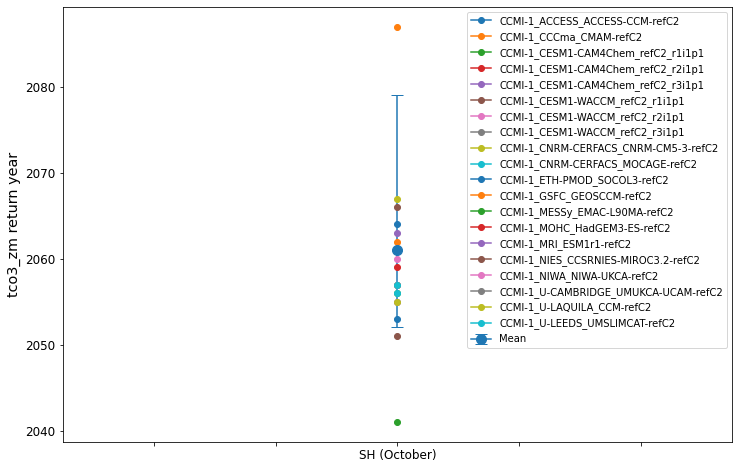

In [47]:
xlabel = 'SH (October)'
tco3_return_models.index = [xlabel]
tco3_return_models.plot(marker='o')
#plt.xticks(rotation=90)
tco3_return_stat.index = [xlabel]
mean_yerr = [ tco3_return_stat['Mean'] - tco3_return_stat['Mean+Std'],
              tco3_return_stat['Mean-Std'] - tco3_return_stat['Mean']]
tco3_return_stat['Mean'].plot(marker='o', markersize=10, yerr=mean_yerr, capsize=6, legend='Mean')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('tco3_zm return year', fontsize='x-large')